# Additional plots
Plots of
- reserve prices from the year 2015 to the year 2019 
- frequency deviations, utility and reserve prices, market bids, driving needs, and the evolution of the state-of-charge with a 10s resolution on 9 August 2019 in the nominal scenario

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Reserve prices

In [3]:
pr = pd.read_hdf('_data/pr.h5')
pr_cts_day = 100*pr['pr'].resample('1d').mean()
pa = pd.read_hdf('_data/pa.h5')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


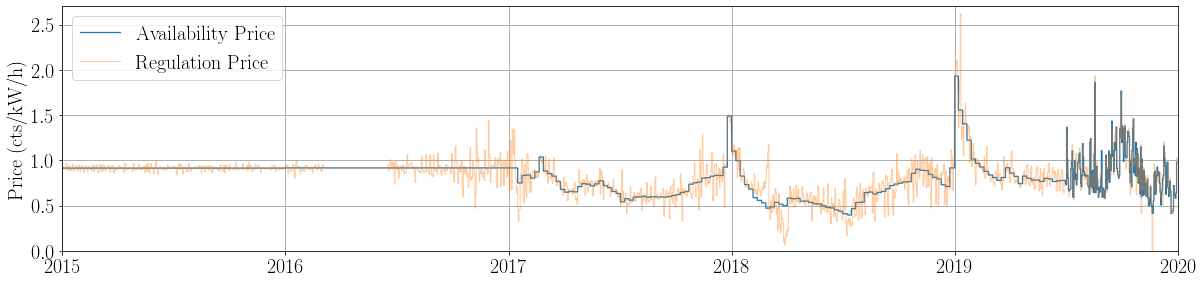

In [4]:
# time horizon
T = pd.date_range('01-01-2015 00:00:00', '12-31-2019 00:00:00', freq='D')
T_lim = pd.date_range('01-01-2015 00:00:00', '01-01-2020 00:00:00', freq='D')
# layout
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
fig = plt.figure(figsize=[20, 4.5])
plt.rcParams.update({'font.size': 20})
# plots
plt.step(T, 100*pa.loc[T], linewidth = 1.25, color = 'tab:blue', alpha = 1, where = 'post', label = 'Availability Price')
plt.step(T, pr_cts_day.loc[T], linewidth = 1, color = 'tab:orange', alpha = 0.4, where = 'post', label = 'Regulation Price')
# layout
plt.legend(loc = 'upper left')
plt.grid(linewidth=1)
plt.ylabel('Price (cts/kW/h)')
plt.xlim((T_lim[0], T_lim[-1]))
plt.ylim((0,2.7))
fig.savefig('regulation_price.pdf',bbox_inches='tight')

## Frequency Deviations, Prices, Market Bids, Driving Needs, and State-of-Charge

In [6]:
# load data
# - frequency deviations
delta = pd.read_hdf('_data/delta_Gmm_2pt5hours.h5')
# - prices
pa = pd.read_hdf('_data/pa.h5')
pb = pd.read_hdf('_data/pb.h5')
pdel = pd.read_hdf('_data/pd.h5')
# - results from base case run: pstar = 0.15, ystar = 54
fname = 'Tuning/Results/2019_54y_0.15p_7kW_50kWh_0.5gmm_2.5Gmm_1d_distance_Exclusion_5kpen_0.75py_False_uni_True_losses_True_regulation_True_robust_True_plan_losses_1_stages_fixed_d_time_noon_bid_time.h5'
dec_soc = pd.read_hdf(fname, key = 'dec_soc')

### State-of-Charge upsampling to 10s resolution

In [7]:
# time horizon
T = pd.date_range('08-09-2019 00:00:00', '08-10-2019 00:00:00', freq='30min')
TT = pd.date_range('08-09-2019 00:00:00', '08-10-2019 00:00:00', freq='10s')
df = pd.DataFrame({'xb': dec_soc.loc[T, 'xb'], 'xr': dec_soc.loc[T, 'xr'], 'd': dec_soc.loc[T, 'd']}, index=T)
df = df.reindex(index = TT, method='ffill')
df['delta'] = delta.loc[TT, 'delta']
# define efficiencies
nc = 0.85
nd = 0.85
# calculate nominal charging
yp = df['xb'] + df['delta'] * df['xr']
# ... and discharging rates
ym = - (df['xb'] + df['delta'] * df['xr'])
# impose their non-negativity
yp[yp < 0] = 0
ym[ym < 0] = 0
# update the state-of-charge accordingly
df['y'] = np.cumsum(nc*yp - ym/nd - df.d) * 10/3600 + dec_soc.loc[T[0], 'y']

### Subplot

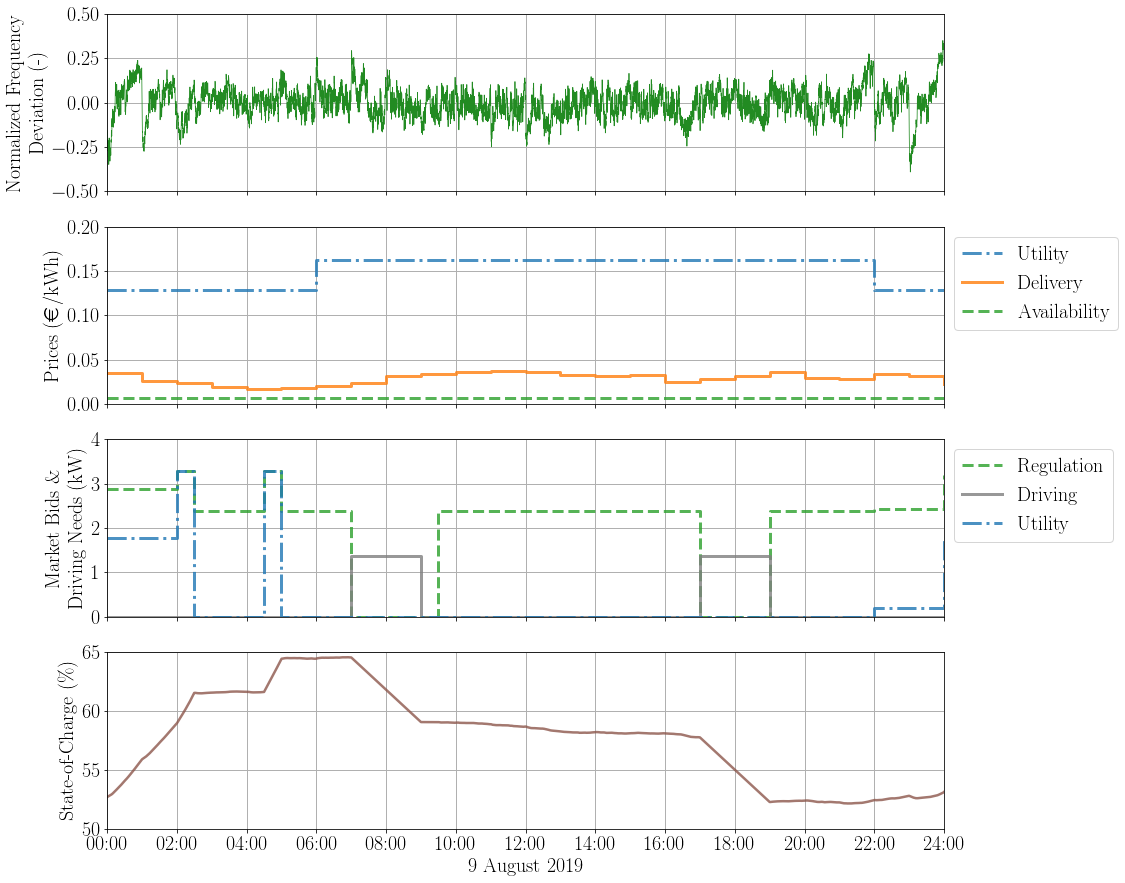

In [8]:
# layout
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 20})
plt.rc('text.latex', preamble=r'\usepackage{eurosym}')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)
fig.set_size_inches(15, 15)
# frequency
Tf = pd.date_range('08-09-2019 00:00:00', '08-10-2019 00:00:00', freq='10s')
ax1.plot(delta.loc[Tf, 'delta'], linewidth = 0.75, color = 'forestgreen')
ax1.grid(linewidth = 1)
ax1.set_ylim([-0.5, 0.5])
ax1.set_ylabel('Normalized Frequency\nDeviation (-)')
# prices
T = pd.date_range('08-09-2019 00:00:00', '08-10-2019 00:00:00', freq='30min')
transp = 0.8
ax2.step(pb.loc[T, 'Tempo'], '-.', linewidth = 3, alpha = transp, label = 'Utility', where = 'post')
ax2.step(T, pdel.loc[T, 'pd'], linewidth = 3, alpha = transp, label = 'Delivery', where = 'post')
ax2.step(pa.loc[T, 'pa'], '--', linewidth = 3, alpha = transp, label = 'Availability', where = 'post')
ax2.grid(linewidth = 1)
ax2.set_ylim([0, 0.20])
ax2.set_ylabel('Prices (\EUR/kWh)')
ax2.legend(bbox_to_anchor=(1,1), loc="upper left")
# market bids and driving needs
ax3.step(T, dec_soc.loc[T, 'xr'], '--', linewidth = 3, alpha = transp, label = 'Regulation', color = 'tab:green', where = 'post')
ax3.step(T, dec_soc.loc[T, 'd'], '-', linewidth = 3, alpha = transp, label = 'Driving', color = 'tab:gray', where = 'post')
ax3.step(T, dec_soc.loc[T, 'xb'], '-.', linewidth = 3, alpha = transp, label = 'Utility', color = 'tab:blue', where = 'post')
ax3.grid(linewidth = 1)
ax3.set_ylim([0, 4])
ax3.set_ylabel('Market Bids \&\n Driving Needs (kW)')
ax3.legend(bbox_to_anchor=(1,1), loc="upper left")
# state-of-charge
ax4.plot(TT, df.loc[TT, 'y']/50*100, '-', linewidth = 2.5, alpha = transp, color = 'tab:brown')
ax4.grid(linewidth = 1)
ax4.set_ylim([50,65])
# ax4.set_yticks([15, 25, 35])
ax4.set_ylabel('State-of-Charge (\%)')
# x-axis
Tres = '2H'
idx = pd.date_range('08-09-2019 00:00:00', '08-09-2019 23:00:00', freq=Tres).strftime('%H:%M').tolist()
idx.append('24:00')
plt.xticks(pd.date_range('08-09-2019 00:00:00', '08-10-2019 00:00:00', freq= Tres), idx)
plt.xlim([T[0], T[-1]])
ax4.set_xlabel('9 August 2019')
# save figure
fig.savefig('9aug.pdf', bbox_inches='tight')